This notebook handles:
1. Loading the NYC 311 dataset (Oct 27 - Nov 27, 2025)
2. Selecting relevant columns for topic modeling
3. Initial data inspection and exploration
4. Text preprocessing (cleaning, tokenization, lemmatization)
5. Saving processed data for vectorization

## 1. Import Libraries

In [1]:
import pandas as pd
from lingua import LanguageDetectorBuilder, Language
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
warnings.filterwarnings('ignore')
from wordcloud import WordCloud


# NLP libraries
import spacy
from nltk.corpus import stopwords
import nltk

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

## 2. Load dataset

In [2]:
# Load the dataset handling large data using chunks
df= pd.read_csv("../data/raw/311_Service_Requests_from_2010_to_Present_20251127.csv", chunksize=10000)
df = pd.concat(df, ignore_index=True)
df.shape

(315117, 41)

In [3]:
df.head()

,Unique Key,Created Date,Closed Date,Agency,Agency Name,Complaint Type,Descriptor,Location Type,Incident Zip,Incident Address,Street Name,Cross Street 1,Cross Street 2,Intersection Street 1,Intersection Street 2,Address Type,City,Landmark,Facility Type,Status,Due Date,Resolution Description,Resolution Action Updated Date,Community Board,BBL,Borough,X Coordinate (State Plane),Y Coordinate (State Plane),Open Data Channel Type,Park Facility Name,Park Borough,Vehicle Type,Taxi Company Borough,Taxi Pick Up Location,Bridge Highway Name,Bridge Highway Direction,Road Ramp,Bridge Highway Segment,Latitude,Longitude,Location
0,66951426,11/26/2025 02:05:58 AM,NaN,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,In Progress,NaN,NaN,NaN,0 Unspecified,NaN,Unspecified,"1,047,282","211,880",ONLINE,Unspecified,Unspecified,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.748014,-73.772514,"(40.748013576775264, -73.77251402713118)"
1,66948831,11/26/2025 02:05:49 AM,NaN,DOHMH,Department of Health and Mental Hygiene,Indoor Air Quality,Chemical Vapors/Gases/Odors,1-2 Family Mixed Use Building,10016.0,50 EAST 28 STREET,EAST 28 STREET,MADISON AVENUE,PARK AVENUE SOUTH,MADISON AVENUE,PARK AVENUE SOUTH,ADDRESS,NEW YORK,EAST 28 STREET,NaN,In Progress,NaN,NaN,NaN,05 MANHATTAN,1.008578e+09,MANHATTAN,"988,384","210,241",ONLINE,Unspecified,MANHATTAN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.743739,-73.985081,"(40.743738612212276, -73.98508113948482)"
2,66947689,11/26/2025 02:05:02 AM,NaN,TLC,Taxi and Limousine Commission,Taxi Complaint,Driver Complaint - Non Passenger,Street,11430.0,JOHN F KENNEDY AIRPORT,JOHN F KENNEDY AIRPORT,BEND,AIRTRAIN-HOWARD BCH/JAMAICA LINE,BEND,AIRTRAIN-HOWARD BCH/JAMAICA LINE,PLACE,JAMAICA,JOHN F KENNEDY AIRPORT,NaN,In Progress,NaN,NaN,NaN,83 QUEENS,4.142600e+09,QUEENS,"1,043,001","175,548",PHONE,Unspecified,QUEENS,NaN,NaN,"JOHN F KENNEDY AIRPORT, QUEENS (JAMAICA) ,NY, 11430",NaN,NaN,NaN,NaN,40.648320,-73.788281,"(40.64832048620134, -73.78828125130184)"
3,66948918,11/26/2025 02:04:45 AM,NaN,NYPD,New York City Police Department,Noise - Street/Sidewalk,Loud Music/Party,Street/Sidewalk,11364.0,58-03 OCEANIA STREET,OCEANIA STREET,58 AVENUE,HORACE HARDING EXPRESSWAY,58 AVENUE,HORACE HARDING EXPRESSWAY,ADDRESS,OAKLAND GARDENS,OCEANIA STREET,NaN,In Progress,NaN,NaN,NaN,11 QUEENS,4.074600e+09,QUEENS,"1,048,386","211,691",ONLINE,Unspecified,QUEENS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.747487,-73.768531,"(40.747486882906074, -73.76853145090132)"
4,66952687,11/26/2025 02:03:57 AM,NaN,NYPD,New York City Police Department,Illegal Parking,Posted Parking Sign Violation,Street/Sidewalk,11213.0,1055 ST JOHNS PLACE,ST JOHNS PLACE,BROOKLYN AVENUE,KINGSTON AVENUE,BROOKLYN AVENUE,KINGSTON AVENUE,ADDRESS,BROOKLYN,ST JOHNS PLACE,NaN,In Progress,NaN,NaN,NaN,08 BROOKLYN,3.012500e+09,BROOKLYN,"999,993","183,840",ONLINE,Unspecified,BROOKLYN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40.671261,-73.943248,"(40.67126108021832, -73.94324808641218)"


## 3. Choosing relevant columns

In [4]:
# Define columns to keep for topic modeling
columns_to_keep = [
    'Unique Key',           # Unique identifier
    'Created Date',         # Temporal context
    'Complaint Type',       # Validation/comparison with topics
    'Descriptor',           # PRIMARY TEXT for topic modeling
    'Agency',               # Responding agency (context)
    'Borough',              # Geographic context
]


In [5]:
# Check which columns exist in the dataset
existing_columns = [col for col in columns_to_keep if col in df.columns]
missing_columns = [col for col in columns_to_keep if col not in df.columns]

print(f"\n✓ Columns selected for topic modeling:")
for col in existing_columns:
    non_null = df[col].notna().sum()
    null_pct = (df[col].isna().sum() / len(df)) * 100
    print(f"  - {col:20s}: {non_null:>8,} non-null ({null_pct:5.1f}% missing)")

if missing_columns:
    print(f"\n⚠ Warning: Missing columns: {missing_columns}")


✓ Columns selected for topic modeling:
  - Unique Key          :  315,117 non-null (  0.0% missing)
  - Created Date        :  315,117 non-null (  0.0% missing)
  - Complaint Type      :  315,117 non-null (  0.0% missing)
  - Descriptor          :  309,696 non-null (  1.7% missing)
  - Agency              :  315,117 non-null (  0.0% missing)
  - Borough             :  315,117 non-null (  0.0% missing)


In [6]:
# Select only relevant columns
df = df[existing_columns].copy()

## 4. Initial data exploration and cleaning

In [7]:
df.head()

,Unique Key,Created Date,Complaint Type,Descriptor,Agency,Borough
0,66951426,11/26/2025 02:05:58 AM,Noise - Street/Sidewalk,Loud Music/Party,NYPD,Unspecified
1,66948831,11/26/2025 02:05:49 AM,Indoor Air Quality,Chemical Vapors/Gases/Odors,DOHMH,MANHATTAN
2,66947689,11/26/2025 02:05:02 AM,Taxi Complaint,Driver Complaint - Non Passenger,TLC,QUEENS
3,66948918,11/26/2025 02:04:45 AM,Noise - Street/Sidewalk,Loud Music/Party,NYPD,QUEENS
4,66952687,11/26/2025 02:03:57 AM,Illegal Parking,Posted Parking Sign Violation,NYPD,BROOKLYN


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 315117 entries, 0 to 315116
Data columns (total 6 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Unique Key      315117 non-null  int64 
 1   Created Date    315117 non-null  object
 2   Complaint Type  315117 non-null  object
 3   Descriptor      309696 non-null  object
 4   Agency          315117 non-null  object
 5   Borough         315117 non-null  object
dtypes: int64(1), object(5)
memory usage: 14.4+ MB


In [9]:
# Check for missing vaslues in the 'Descriptor' column
df['Descriptor'].isna().sum()

np.int64(5421)

In [10]:
# Drop rows with missing 'Descriptor' values
df = df.dropna(subset=['Descriptor']).reset_index(drop=True)
df.shape

(309696, 6)

In [11]:
# Check for duplicates
df.duplicated(subset=['Unique Key']).sum()

np.int64(0)

In [12]:
# Filter out very short descriptors (less than 10 characters)
df = df[df['Descriptor'].str.len() >= 10].reset_index(drop=True)
df.shape

(258233, 6)

In [13]:
# Check for non-English entries in 'Descriptor' column
# Build detector
detector = LanguageDetectorBuilder.from_all_languages().with_preloaded_language_models().build()

# Detection function
def detect_language(text):
    s = str(text).strip()
    if not s or len(s) < 20:  # Assume English for very short/empty
        return 'en', 1.0
    
    lang = detector.detect_language_of(s)
    if lang is None:
        return 'unknown', 0.0
    
    conf = detector.compute_language_confidence(s, lang)
    code = lang.iso_code_639_1.name.lower() if hasattr(lang.iso_code_639_1, 'name') else lang.name.lower()
    return code, conf

# Apply detection
df["lang"], df["lang_conf"] = zip(*df["Descriptor"].apply(detect_language))

In [14]:
# Show some non-English samples
non_en = df[(df["lang"] != "en") & (df["lang"] != "unknown")].head(10)
print("\nSample non-English texts:")
for _, row in non_en.iterrows():
    print(f"- [{row['lang']} | {row['lang_conf']:.2f}] {str(row['Descriptor'])[:100]}...")

# Count non_english detected text
print("\nNumber of non english texts:")
df[df['lang'] != 'en'].shape[0]


Sample non-English texts:
- [la | 0.16] Bodega, Deli, or Convenience Store...
- [it | 0.15] BELL/BUZZER/INTERCOM...
- [nb | 0.18] Driver Report - Passenger...
- [it | 0.15] BELL/BUZZER/INTERCOM...
- [it | 0.15] BELL/BUZZER/INTERCOM...
- [it | 0.15] BELL/BUZZER/INTERCOM...
- [it | 0.15] BELL/BUZZER/INTERCOM...
- [la | 0.16] No Permit or License...
- [it | 0.15] BELL/BUZZER/INTERCOM...
- [it | 0.15] BELL/BUZZER/INTERCOM...

Number of non english texts:


1795

Language detection flagged ~0.57% as non-English, but samples confirmed English; no filtering applied to preserve dataset integrity.

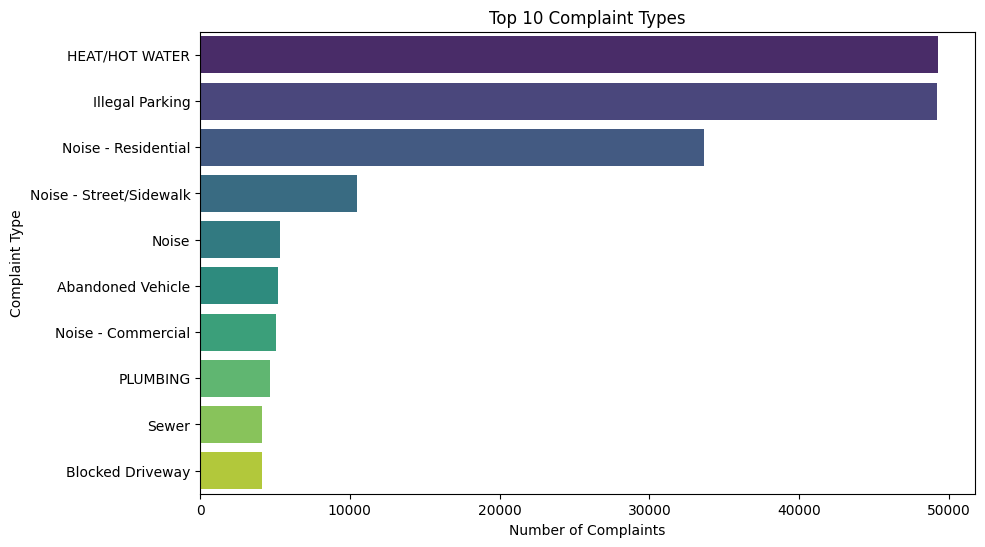

In [15]:
# Complaint types distribution
complaint_counts = df['Complaint Type'].value_counts().head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=complaint_counts.values, y=complaint_counts.index, palette='viridis')
plt.title('Top 10 Complaint Types')
plt.xlabel('Number of Complaints')  
plt.ylabel('Complaint Type')
plt.show()


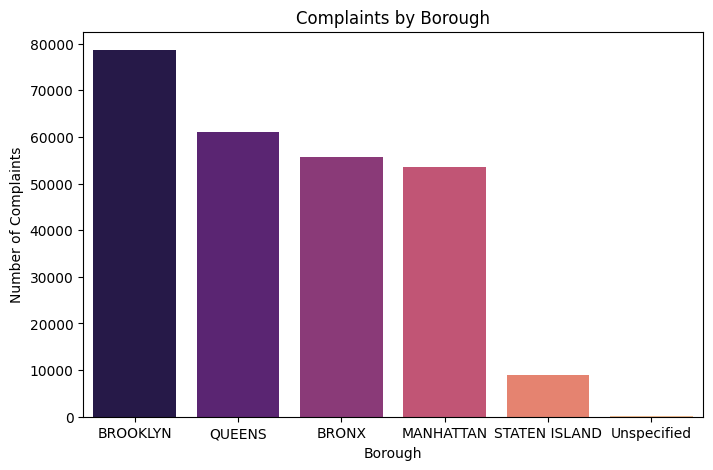

In [16]:
# Borough distribution
borough_counts = df['Borough'].value_counts()
plt.figure(figsize=(8,5))
sns.barplot(x=borough_counts.index, y=borough_counts.values, palette='magma')
plt.title('Complaints by Borough')
plt.xlabel('Borough')
plt.ylabel('Number of Complaints')
plt.show()

## 5. Text Preprocessing

In [17]:
# Load spaCy model
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

In [18]:
# Load nltk stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Add custom stopwords if needed
custom_stopwords = {
    'new', 'york', 'nyc', 'city', 'borough', 'street', 'avenue', 
    'ave', 'st', 'road', 'rd', 'block', 'building', 'apartment',
    'please', 'thank', 'thanks', 'yes', 'no', 'need', 'want'
}

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\quadr\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [19]:
stop_words.update(custom_stopwords)

Preprocess text following the conception phase methodology:
1. Lowercasing
2. Noise removal (URLs, special characters, punctuation)
3. Tokenization
4. Stopword elimination
5. Lemmatization
6. Short token filtering (< 3 characters)

In [20]:
# Preprocessing function
def preprocess_text(text):
    if not isinstance(text, str) or len(text.strip()) == 0:
        return ""
    # 1. Lowercasing
    text = text.lower()

    # 2. Remove URLs, email addresses, special characters and numbers, and extra whitespace
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'\S+@\S+', '', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    
    # Skip if text is too short after cleaning
    if len(text) < 5:
        return ""
    
    # 3-6. Process with spaCy: tokenization, lemmatization, filtering
    doc = nlp(text)
    
    # Filter: remove stopwords, keep only alphabetic, length >= 3
    tokens = [
        token.lemma_ for token in doc 
        if token.is_alpha 
        and len(token.lemma_) >= 3 
        and token.lemma_ not in stop_words
    ]
    
    return ' '.join(tokens)


### Batch Processing

In [21]:
# batch processing
batch_size = 10000
num_batches = (len(df) + batch_size - 1) // batch_size
print(f"Processing {len(df)} records in {num_batches} batches of up to {batch_size} each.")

Processing 258233 records in 26 batches of up to 10000 each.


In [22]:
processed_texts = []
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = min((i + 1) * batch_size, len(df))
    batch_texts = df['Descriptor'].iloc[start_idx:end_idx].tolist()
    
    print(f"Processing batch {i+1}/{num_batches} (records {start_idx} to {end_idx-1})...")
    
    for text in batch_texts:
        processed_text = preprocess_text(text)
        processed_texts.append(processed_text)
# Add processed texts to DataFrame
df['processed_text'] = processed_texts

Processing batch 1/26 (records 0 to 9999)...
Processing batch 2/26 (records 10000 to 19999)...
Processing batch 3/26 (records 20000 to 29999)...
Processing batch 4/26 (records 30000 to 39999)...
Processing batch 5/26 (records 40000 to 49999)...
Processing batch 6/26 (records 50000 to 59999)...
Processing batch 7/26 (records 60000 to 69999)...
Processing batch 8/26 (records 70000 to 79999)...
Processing batch 9/26 (records 80000 to 89999)...
Processing batch 10/26 (records 90000 to 99999)...
Processing batch 11/26 (records 100000 to 109999)...
Processing batch 12/26 (records 110000 to 119999)...
Processing batch 13/26 (records 120000 to 129999)...
Processing batch 14/26 (records 130000 to 139999)...
Processing batch 15/26 (records 140000 to 149999)...
Processing batch 16/26 (records 150000 to 159999)...
Processing batch 17/26 (records 160000 to 169999)...
Processing batch 18/26 (records 170000 to 179999)...
Processing batch 19/26 (records 180000 to 189999)...
Processing batch 20/26 (rec

In [23]:
# Results after preprocessing
df[['Descriptor', 'processed_text']].head(10)

,Descriptor,processed_text
0,Loud Music/Party,loud music party
1,Chemical Vapors/Gases/Odors,chemical vapor gas odor
2,Driver Complaint - Non Passenger,driver complaint non passenger
3,Loud Music/Party,loud music party
4,Posted Parking Sign Violation,post parking sign violation
5,Driver Complaint - Non Passenger,driver complaint non passenger
6,Car/Truck Horn,car truck horn
7,With License Plate,license plate
8,Broken Curb,break curb
9,Banging/Pounding,bang pound


In [24]:
# Remove rows with empty processed texts
df = df[df['processed_text'].str.strip() != ''].reset_index(drop=True)  
df.shape

(242348, 9)

In [25]:
# Calculate text statistics
df['token_count'] = df['processed_text'].str.split().str.len()
df['char_count'] = df['processed_text'].str.len()

# Text Statistics
df[['token_count', 'char_count']].describe()

,token_count,char_count
count,242348.000000,242348.000000
mean,2.324496,14.934181
std,1.153987,8.406305
min,1.000000,3.000000
25%,1.000000,9.000000
50%,2.000000,14.000000
75%,3.000000,18.000000
max,10.000000,64.000000


In [26]:
# Save the processed DataFrame
df.to_csv("../data/processed/processed_complaints.csv", index=False)

## 6. Final Statistics & Visualizations

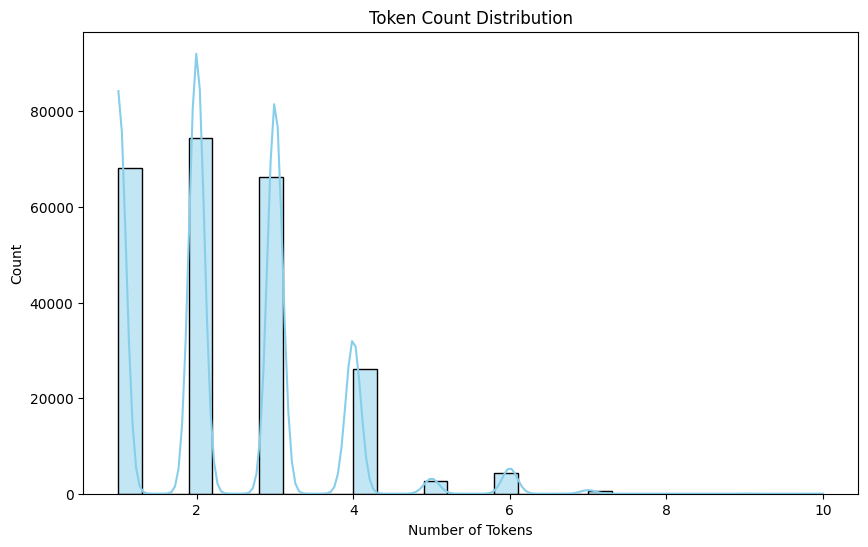

In [27]:
# 1. Token count distribution
plt.figure(figsize=(10,6))
sns.histplot(df['token_count'], bins=30, kde=True, color='skyblue')
plt.title('Token Count Distribution')
plt.xlabel('Number of Tokens')
plt.show()

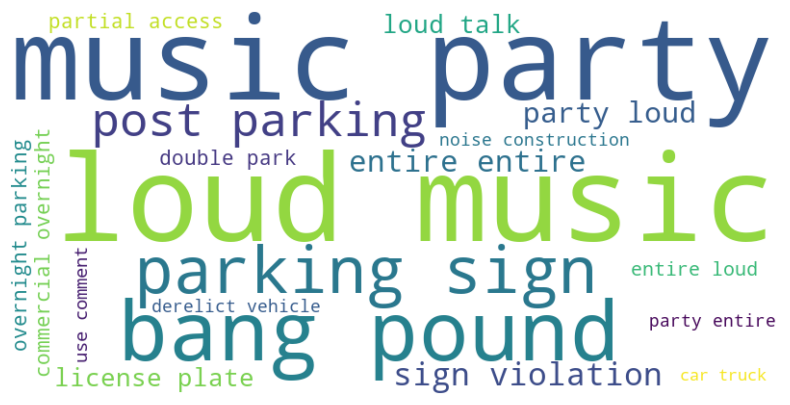

In [28]:
# 2. Top 20 most common words using WordCloud
all_words = ' '.join(df['processed_text']).split()
wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=20).generate(' '.join(all_words))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()